In [90]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

## basic parameters

In [91]:
### basic quantities
# initial stock price
s0 = 100 
# strike price
k = 105
# years to maturity
maturity = 1/6 
# standard deviation/volatility
sd = 0.25 
# delta t : 1 for a year. normally 1/52 for a week. 
# But to make this value align with m, we use 1/48 as the estimated value 
dt = 1/48 
# risk free rate
rf = 0.02
# sample size
n = 2000
# number of weeks until maturity.maturity/unit time = 8 period for each path.
m = 8 

## Monte Carlo simulations

In [92]:
simu_paths = [] # store all paths for simulation.

In [93]:
for i in range(n):
    path = [] # # store a single path. reset for every sample iteration(every n)
    path.append(s0)
    for j in range(m):
        z = np.random.normal(0,1)
        # growth factor is independent of m,n.
        # the growth factor for each period(3.1 in paper)        
        growth_factor = np.exp((rf-(sd**2)/2)*dt+sd*np.sqrt(dt)*z)
        path.append(path[-1]*growth_factor)
    simu_paths.append(path)

In [94]:
np.array(simu_paths)

array([[100.        ,  94.11580306,  96.92094246, ..., 107.86518618,
        106.83591708, 111.09216401],
       [100.        ,  97.30660849,  91.76499445, ...,  78.89296997,
         84.43226564,  83.52024203],
       [100.        ,  98.13120849,  98.72614135, ...,  99.57246836,
         96.76625261,  97.61934255],
       ...,
       [100.        ,  96.69242347,  98.09334124, ...,  98.43290208,
        102.24626841, 100.56751854],
       [100.        , 101.28378357,  97.7641422 , ..., 102.3652622 ,
        100.74833216, 101.64513975],
       [100.        ,  95.96174941,  93.76213309, ...,  97.9669504 ,
         95.50057889,  95.16971783]])

In [95]:
np.array(simu_paths).shape

(2000, 9)

In [96]:
simu_paths = np.array(simu_paths)
s_mean = simu_paths.mean(axis = 1)
s_min = simu_paths.min(axis = 1)
s_max = simu_paths.max(axis = 1)

## compute prices for options

In [97]:
discount_factor = np.exp(-rf * maturity)

In [98]:
# Asian call option
#payoff for each simulation path
payoff_ac = np.maximum(s_mean -k, 0) 
# compute estimated price 
p_ac = np.mean(payoff_ac)*discount_factor
# compute standard deviation of the payoffs
std_ac = np.std(payoff_ac)      
lb_ac = p_ac-1.96*std_ac/np.sqrt(n)
ub_ac = p_ac+1.96*std_ac/np.sqrt(n)

In [99]:
# Asian put option
payoff_ap = np.maximum(k - s_mean, 0)       
p_ap = np.mean(payoff_ap)*discount_factor       
std_ap = np.std(payoff_ap)   
lb_ap = p_ap-1.96*std_ap/np.sqrt(n)
ub_ap = p_ap+1.96*std_ap/np.sqrt(n)

In [100]:
# Lookback call option
payoff_lc = np.maximum(s_max - k, 0)       
p_lc = np.mean(payoff_lc)*discount_factor    
std_lc = np.std(payoff_lc)   
lb_lc = p_lc-1.96*std_lc/np.sqrt(n)
ub_lc = p_lc+1.96*std_lc/np.sqrt(n)

In [101]:
# Lookback put option
payoff_lp = np.maximum(k - s_min, 0)      
p_lp = np.mean(payoff_lp)*discount_factor    
std_lp = np.std(payoff_lp)  
lb_lp = p_lp-1.96*std_lp/np.sqrt(n)
ub_lp = p_lp+1.96*std_lp/np.sqrt(n)

In [102]:
# Floating lookback call option
payoff_fc = simu_paths[:, -1]- s_min       
p_fc = np.mean(payoff_fc)*discount_factor      
std_fc = np.std(payoff_fc)   
lb_fc = p_fc-1.96*std_fc/np.sqrt(n)
ub_fc = p_fc+1.96*std_fc/np.sqrt(n)

In [103]:
# Floating lookback put option
payoff_fp = s_max - simu_paths[:, -1]      
p_fp = np.mean(payoff_fp)*discount_factor       
std_fp = np.std(payoff_fp)  
lb_fp = p_fp-1.96*std_fp/np.sqrt(n)
ub_fp = p_fp+1.96*std_fp/np.sqrt(n)

In [104]:
print(f"stats for options")
dict1={'Asian call':[p_ac,std_ac,np.round([lb_ac,ub_ac],3)],
         'Asian put':[p_ap,std_ap,np.round([lb_ap,ub_ap],3)],
        'Lookback call':[p_lc,std_lc,np.round([lb_lc,ub_lc],3)],
        'Lookback put': [p_lp,std_lp,np.round([lb_lp,ub_lp],3)],
        'Floating lookback call': [p_fc,std_fc,np.round([lb_fc,ub_fc],3)],
        'Floating lookback put' : [p_fp,std_fp,np.round([lb_fp,ub_fp],3)]}
results = pd.DataFrame(dict1, index = ['estimated_price','volatility','95%_confidence_interval'])
results = results.T
results[['estimated_price','volatility']] = results[['estimated_price','volatility']].astype(float).round(3)
results

stats for options


,estimated_price,volatility,95%_confidence_interval
Asian call,0.678,1.966,"[0.591, 0.764]"
Asian put,5.611,4.705,"[5.405, 5.817]"
Lookback call,3.214,5.313,"[2.981, 3.447]"
Lookback put,11.071,5.624,"[10.824, 11.317]"
Floating lookback call,6.298,6.498,"[6.013, 6.582]"
Floating lookback put,6.191,5.648,"[5.943, 6.438]"


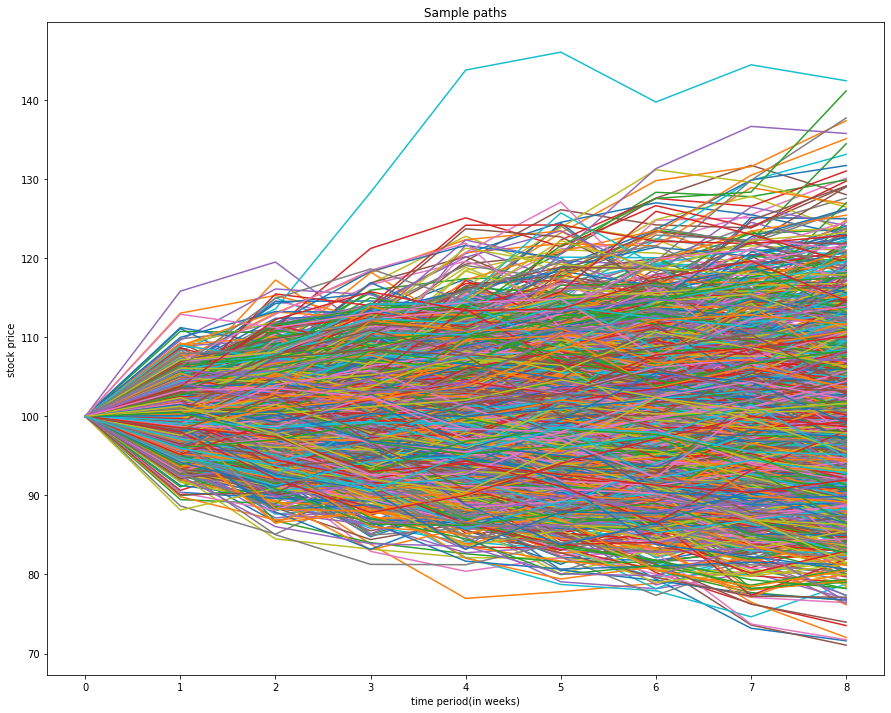

In [105]:
# plot the simulation paths
x_values=np.arange(m+1)
plt.figure(figsize=(15,12))
for i in range(n):
    plt.plot(x_values,simu_paths[i])
plt.title('Sample paths')
plt.xlabel('time period(in weeks)')
plt.ylabel('stock price')
plt.show()

In [106]:
def american_put_simulation():    
    # pricing of American put option using Black-Scholes model and Monte Carlo simulation
    stop_time_list=[]
    price_list=[]

    for i in range(n):
        stop_time=None
        stock_price=s0
        for j in range(m):
            #compute remaining time        
            remain_time=maturity-j*dt
            #(i)compute d1,d2
            d1=(np.log(stock_price/k)+(rf+(sd**2)/2)*remain_time)/(sd*np.sqrt(remain_time))
            d2=d1-(sd*np.sqrt(remain_time))        
            # current stock price
            z = np.random.normal(0,1)   
            growth_factor = np.exp((rf-(sd**2)/2)*dt+sd*np.sqrt(dt)*z)
            stock_price=stock_price*growth_factor        


            #(ii)compute E(ST|St)
            premium_price=k*np.exp(-rf*remain_time)*norm.cdf(-d2,0,1)-stock_price*norm.cdf(-d1,0,1)

            #(iii)compute payoff
            current_payoff= max(k-stock_price,0)

            #(iv) compute optimal stopping time
            if current_payoff >= premium_price:
                # tj = j*dt
                stop_time=j*dt
            else: pass

        if stop_time==None:
            stop_time=maturity
        # present value of payoff at Ti. hi = zTi
        hi=current_payoff*np.exp(-rf*stop_time)   
        # record stop time
        stop_time_list.append(stop_time)
        # record present value of payoffs for every path
        price_list.append(hi)

    avg_stoptime=np.array(stop_time_list).mean()
    std_stoptime=np.array(stop_time_list).std()
    var_stoptime=np.array(stop_time_list).var()
    avg_payoff=np.array(price_list).mean()
    std_payoff=np.array(price_list).std()
    var_payoff=np.array(price_list).var()

    p_lb = avg_payoff-1.96*std_payoff/np.sqrt(n)
    p_ub = avg_payoff+1.96*std_payoff/np.sqrt(n) 

    t_lb = avg_stoptime-1.96*std_stoptime/np.sqrt(n)
    t_ub = avg_stoptime+1.96*std_stoptime/np.sqrt(n)             


    print('Price of American put option:')
    print(avg_payoff)
    print('\nAmerican put option price 95% confidence interval:')
    print('[',p_lb,',',p_ub,']')
    print('\nAverage stopping time:')
    print(avg_stoptime)
    print('\nstop time 95% confidence interval:')
    print('[',t_lb,',',t_ub,']')
    return avg_payoff


In [107]:
p_american_put = american_put_simulation()

Price of American put option:
6.847594891578084

American put option price 95% confidence interval:
[ 6.5329701796450586 , 7.16221960351111 ]

Average stopping time:
0.13935416666666664

stop time 95% confidence interval:
[ 0.13816954986285412 , 0.14053878347047916 ]


# Lattice Approach

In [108]:
# Parameters in lattice method
import numpy as np
u = np.exp(sd*np.sqrt(dt))
d = 1/u
a = np.exp(rf*dt)
p = (a-d)/(u-d)
# Get the lattice
def Lattice(T,s0,u,d):
    bi_tree_lattice = [[]]*(T+1)
    for i in range(T+1):
        bi_tree_lattice[i] = s0*(u/d)**np.linspace(0,i,i+1)*d**i
    return bi_tree_lattice

Lattice(m,s0,u,d)        

[array([100.]),
 array([ 96.45588892, 103.67433355]),
 array([ 93.03738507, 100.        , 107.48367436]),
 array([ 89.74003679,  96.45588892, 103.67433355, 111.43298307]),
 array([ 86.5595502 ,  93.03738507, 100.        , 107.48367436,
        115.52740254]),
 array([ 83.49178359,  89.74003679,  96.45588892, 103.67433355,
        111.43298307, 119.77226465]),
 array([ 80.53274203,  86.5595502 ,  93.03738507, 100.        ,
        107.48367436, 115.52740254, 124.17309715]),
 array([ 77.6785722 ,  83.49178359,  89.74003679,  96.45588892,
        103.67433355, 111.43298307, 119.77226465, 128.73563091]),
 array([ 74.92555731,  80.53274203,  86.5595502 ,  93.03738507,
        100.        , 107.48367436, 115.52740254, 124.17309715,
        133.46580739])]

In [109]:
# Asian call option
total_num_path = 2**m
lat_0 = Lattice(m,s0,u,d)
asian_call_payout_paths = []
for i in range(total_num_path):
    binary_path = format(i,'0'+str(m)+ "b")
    actual_path = np.cumsum([int(j) for j in binary_path])
    path_sum = s0
    for j in range(m):
        path_sum+=lat_0[j+1][actual_path[j]]
    path_ave = path_sum/(m+1)
    asian_call_payout_paths.append(max([path_ave-k,0]))
asian_call_price = np.mean(asian_call_payout_paths)*np.exp(-rf*dt*m)
asian_call_price

0.7125831574371941

In [110]:
# Asian put option
total_num_path = 2**m
lat_0 = Lattice(m,s0,u,d)
asian_put_payout_paths = []
for i in range(total_num_path):
    binary_path = format(i,'0'+str(m)+ "b")
    actual_path = np.cumsum([int(j) for j in binary_path])
    path_sum = s0
    for j in range(m):
        path_sum+=lat_0[j+1][actual_path[j]]
    path_ave = path_sum/(m+1)
    asian_put_payout_paths.append(max([k-path_ave,0]))
asian_put_price = np.mean(asian_put_payout_paths)*np.exp(-rf*dt*m)
asian_put_price

5.435971264480178

In [111]:
# Lookback call option
total_num_path = 2**m
lat_0 = Lattice(m,s0,u,d)
lkb_call_payout_paths = []
for i in range(total_num_path):
    binary_path = format(i,'0'+str(m)+ "b")
    actual_path = np.cumsum([int(j) for j in binary_path])
    path_max = s0
    for j in range(m):
        if lat_0[j+1][actual_path[j]]>path_max:
            path_max=lat_0[j+1][actual_path[j]]
    lkb_call_payout_paths.append(max([path_max-k,0]))
lkb_call_price = np.mean(lkb_call_payout_paths)*np.exp(-rf*dt*m)
lkb_call_price

3.650860527216179

In [112]:
# Lookback put option
total_num_path = 2**m
lat_0 = Lattice(m,s0,u,d)
lkb_put_payout_paths = []
for i in range(total_num_path):
    binary_path = format(i,'0'+str(m)+ "b")
    actual_path = np.cumsum([int(j) for j in binary_path])
    path_min = s0
    for j in range(m):
        if lat_0[j+1][actual_path[j]]<path_min:
            path_min=lat_0[j+1][actual_path[j]]
    lkb_put_payout_paths.append(max([k-path_min,0]))
lkb_put_price = np.mean(lkb_put_payout_paths)*np.exp(-rf*dt*m)
lkb_put_price

11.162681659945644

In [113]:
# Floating lookback call option
total_num_path = 2**m
lat_0 = Lattice(m,s0,u,d)
float_lkb_call_payout_paths = []
for i in range(total_num_path):
    binary_path = format(i,'0'+str(m)+ "b")
    actual_path = np.cumsum([int(j) for j in binary_path])
    path_min = s0
    for j in range(m):
        if lat_0[j+1][actual_path[j]]<path_min:
            path_min=lat_0[j+1][actual_path[j]]
    float_lkb_call_payout_paths.append(lat_0[m][actual_path[m-1]]-path_min)
float_lkb_call_price = np.mean(float_lkb_call_payout_paths)*np.exp(-rf*dt*m)
float_lkb_call_price

6.699661664559842

In [114]:
# Floating lookback put option
total_num_path = 2**m
lat_0 = Lattice(m,s0,u,d)
float_lkb_put_payout_paths = []
for i in range(total_num_path):
    binary_path = format(i,'0'+str(m)+ "b")
    actual_path = np.cumsum([int(j) for j in binary_path])
    path_max = s0
    for j in range(m):
        if lat_0[j+1][actual_path[j]]>path_max:
            path_max=lat_0[j+1][actual_path[j]]
    float_lkb_put_payout_paths.append(path_max-lat_0[m][actual_path[m-1]])
float_lkb_put_price = np.mean(float_lkb_put_payout_paths)*np.exp(-rf*dt*m)
float_lkb_put_price

6.462218212941761

## Pricing American Option using Lattice approach

In [115]:
# American put option
lat_0 = Lattice(m,s0,u,d)
pricing_lat = lat_0
for node in range(m+1):
    pricing_lat[-1][node] = max([k-lat_0[-1][node],0])
for date in range(m):
    for node in range(m-date):
        pricing_lat[m-date-1][node] = max([(p*pricing_lat[m-date][node+1]+(1-p)*pricing_lat[m-date][node])*np.exp(-rf*dt),k-lat_0[m-date-1][node]])
american_put_price = pricing_lat[0][0]
american_put_price

7.03216596414448

## comparison of results

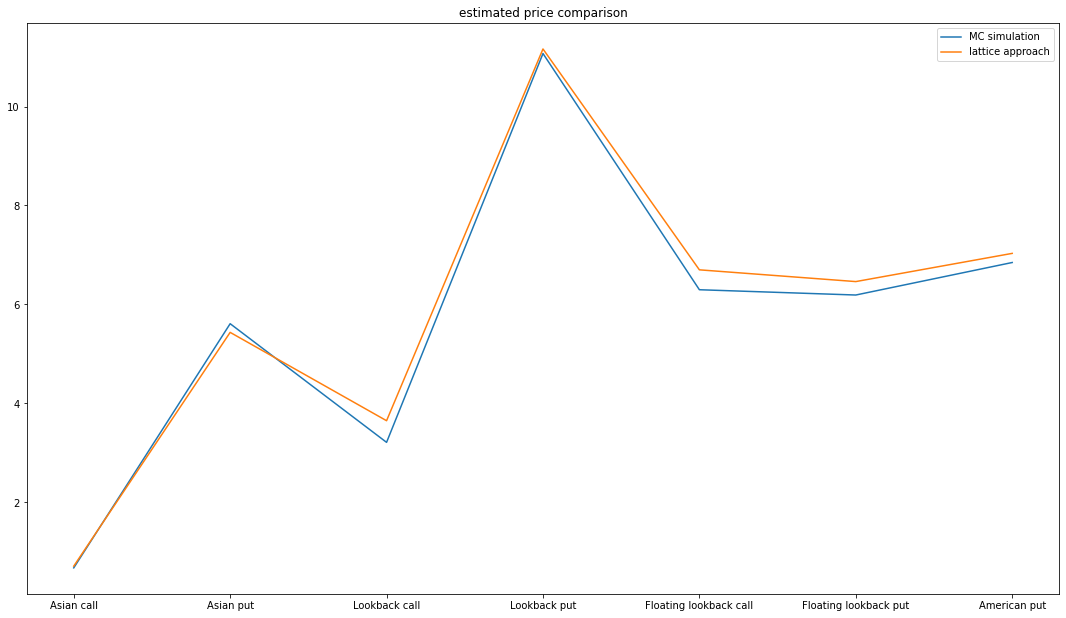

In [116]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
x = np.array([0,1,2,3,4,5,6])
y_m = np.array([p_ac,p_ap,p_lc,p_lp,p_fc,p_fp,p_american_put])
y_l = np.array([asian_call_price,asian_put_price,lkb_call_price,lkb_put_price,float_lkb_call_price,float_lkb_put_price,american_put_price])
my_xticks = ['Asian call','Asian put','Lookback call','Lookback put', 'Floating lookback call',"Floating lookback put", 'American put']
plt.xticks(x, my_xticks)
plt.title("estimated price comparison")
plt.plot(x, y_m, label = 'MC simulation')
plt.plot(x, y_l, label = 'lattice approach')
plt.legend()
plt.show()